In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import sys
sys.path.insert(0,'..')
from scipy.special import softmax
from scipy.stats import entropy
from scipy.spatial.distance import jensenshannon
from scipy.stats import pearsonr
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import glob
from datasets import load_dataset
import json
import matplotlib.path as mpath
from tqdm import tqdm

from util.datareader import read_penn_treebank_transformers, aggregate, get_crowdkit_distributions, get_annotation_matrix, POS_LABEL_MAP, normalized_distribution, softmax_distribution, crowdkit_classes, CustomCINICDataset
from reliability_diagrams import *

/Users/vcx366/anaconda3/envs/annotator-disagreement-uncertainty-2/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
metrics_dir = '/Users/vcx366/Research/hendrix/learning-from-crowd-annotations/metrics/ds_mace_glad_wawa_zbs_softmax_standard/'

pos_logits = [
    ('DS', 'pos-ood/kld-ds/logits_*'),
    ('Softmax', 'pos-ood/kld-softmax/logits_*'),
    ('Standard', 'pos-ood/kld-standard/logits_*'),
    ('MACE', 'pos-ood/kld-mace/logits_*'),
    ('GLAD', 'pos-ood/kld-glad/logits_*'),
    ('WaWA', 'pos-ood/kld-wawa/logits_*'),
    ('ZBS', 'pos-ood/kld-zbs/logits_*'),
    ('Agg', 'pos-ood/kld-ensemble_basic/logits_*'),
    #('Majority', 'pos-ood/majority/logits_*')
]

In [8]:
ptb_data = read_penn_treebank_transformers()
gold_labels = np.array([l for sample in ptb_data['gold'] for l in sample], dtype=np.int32)

In [9]:
data = defaultdict(dict)
for name, loc_super in pos_logits:
    all_logits = []
    for fname in glob.glob(f"{metrics_dir}/{loc_super}"):
        all_logits.append(np.load(fname))
    logits = np.array(all_logits).mean(0)
    print(logits.shape)
    pred = logits.argmax(-1).astype(np.int32)
    conf = softmax(logits, -1).max(-1)
    data[name]['true_labels'] = gold_labels
    data[name]['pred_labels'] = pred
    data[name]['confidences'] = conf

(100676, 12)
(100676, 12)
(100676, 12)
(100676, 12)
(100676, 12)
(100676, 12)
(100676, 12)
(100676, 12)


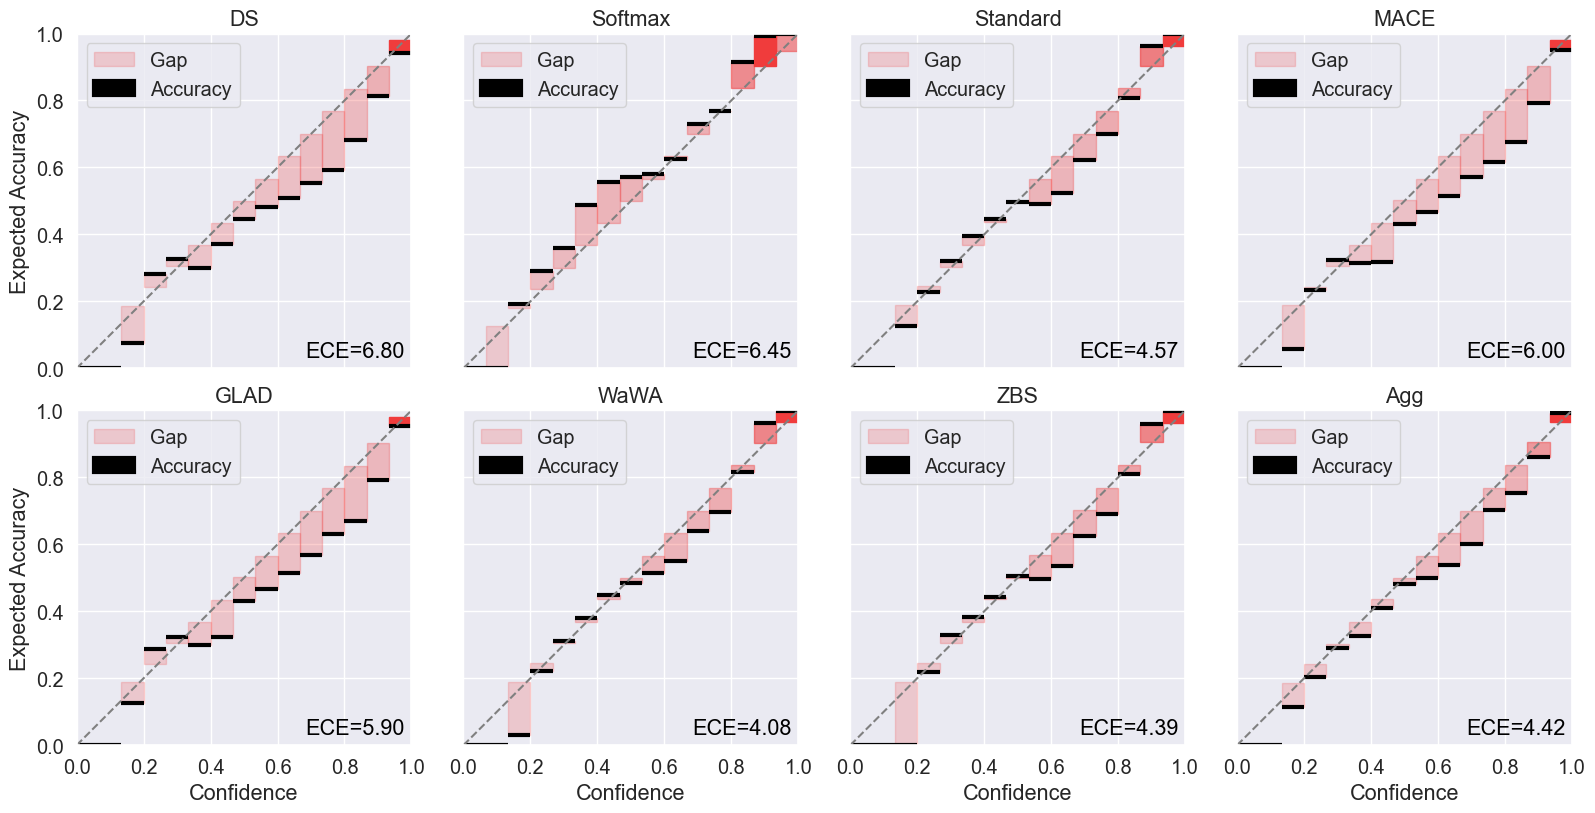

In [10]:
with sns.plotting_context("notebook", font_scale=1.4):
    fig = reliability_diagrams(data, num_bins=15, draw_ece=True,
                              draw_bin_importance="alpha", dpi=100, 
                              return_fig=True)
    fig.savefig('./pos_reliability.pdf')

In [11]:
rte_logits = [
    ('DS', 'rte-ood-snli/kld-ds/logits_*'),
    ('Softmax', 'rte-ood-snli/kld-softmax/logits_*'),
    ('Standard', 'rte-ood-snli/kld-standard/logits_*'),
    ('MACE', 'rte-ood-snli/kld-mace/logits_*'),
    ('GLAD', 'rte-ood-snli/kld-glad/logits_*'),
    ('WaWA', 'rte-ood-snli/kld-wawa/logits_*'),
    ('ZBS', 'rte-ood-snli/kld-zbs/logits_*'),
    ('Agg', 'rte-ood-snli/kld-ensemble_basic/logits_*'),
    #('Majority', 'pos-ood/majority/logits_*')
]

In [12]:
snli_gold = np.array([int(l) for l in load_dataset('snli')['validation'].filter(lambda example: example['label'] >= 0)['label']], dtype=np.int32)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 22.96it/s]


In [13]:
data = defaultdict(dict)
for name, loc_super in rte_logits:
    all_logits = []
    for fname in glob.glob(f"{metrics_dir}/{loc_super}"):
        all_logits.append(np.load(fname))
    logits = np.array(all_logits).mean(0)
    print(logits.shape)
    pred = logits.argmax(-1).astype(np.int32)
    conf = softmax(logits, -1).max(-1)
    data[name]['true_labels'] = snli_gold
    data[name]['pred_labels'] = pred
    data[name]['confidences'] = conf

(9842, 2)
(9842, 2)
(9842, 2)
(9842, 2)
(9842, 2)
(9842, 2)
(9842, 2)
(9842, 2)


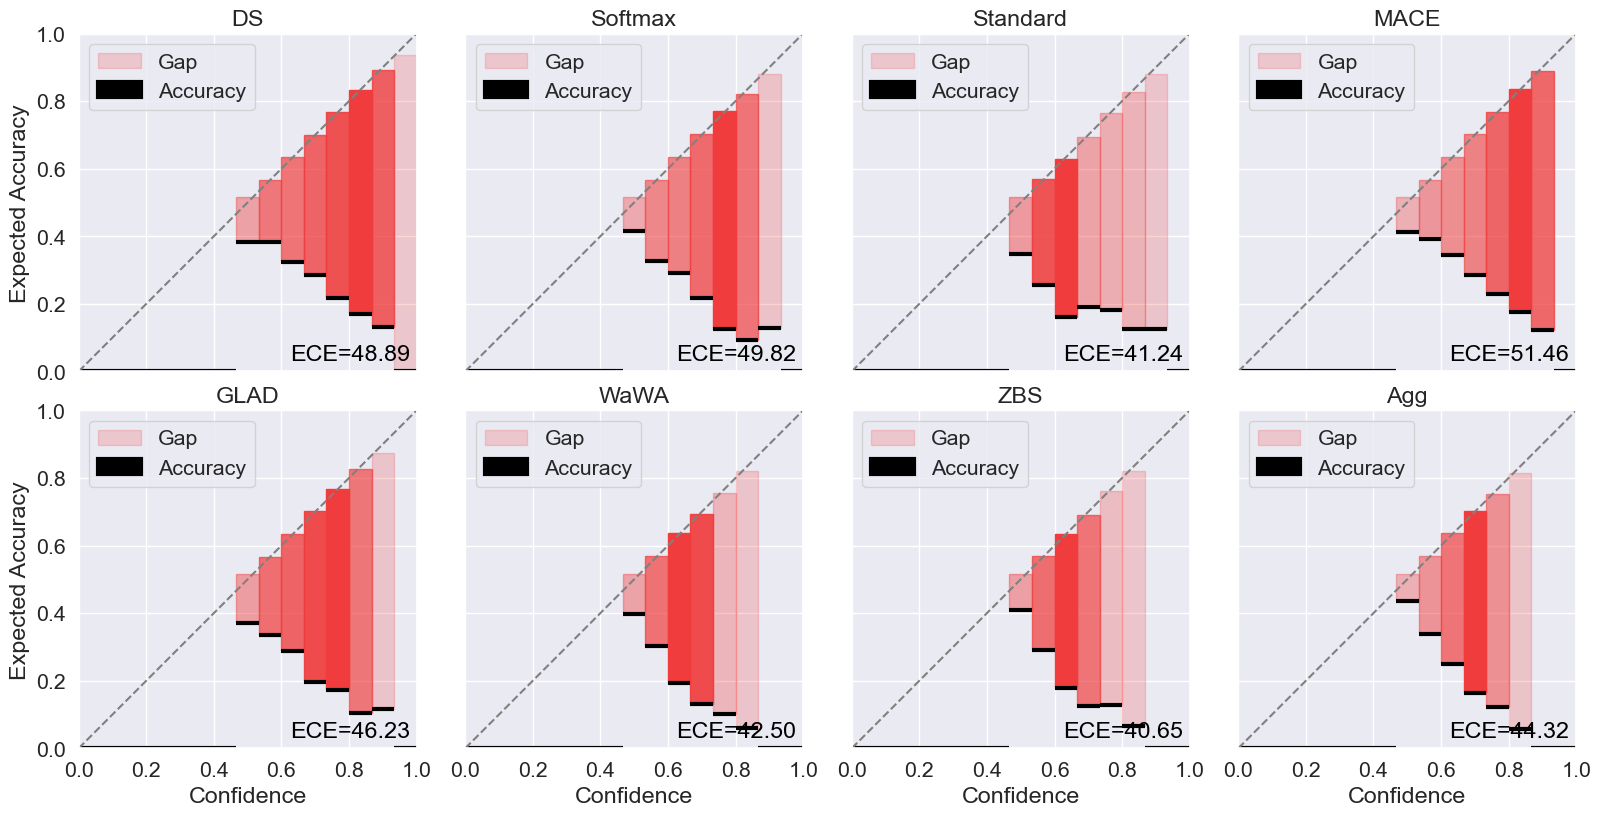

In [14]:
with sns.plotting_context("notebook", font_scale=1.4):
    fig = reliability_diagrams(data, num_bins=15, draw_ece=True,
                              draw_bin_importance="alpha", dpi=100, 
                              return_fig=True)
    fig.savefig('./rte_reliability.pdf')

In [15]:
cifar_logits = [
    ('DS', 'cifar10h/kld-ds/logits_*'),
    ('Softmax', 'cifar10h/kld-softmax/logits_*'),
    ('Standard', 'cifar10h/kld-standard/logits_*'),
    ('MACE', 'cifar10h/kld-mace/logits_*'),
    ('GLAD', 'cifar10h/kld-glad/logits_*'),
    ('WaWA', 'cifar10h/kld-wawa/logits_*'),
    ('ZBS', 'cifar10h/kld-zbs/logits_*'),
    ('Agg', 'cifar10h/kld-ensemble_basic/logits_*'),
    #('Majority', 'cifar10h/majority/logits_*')
]

In [16]:
cinic_gold = np.concatenate([[i]*21000 for i in range(10)], dtype=np.int32)

In [17]:
data = defaultdict(dict)
for name, loc_super in tqdm(cifar_logits):
    all_logits = []
    for fname in glob.glob(f"{metrics_dir}/{loc_super}"):
        all_logits.append(np.load(fname))
    logits = np.array(all_logits).mean(0)
    pred = logits.argmax(-1).astype(np.int32)
    conf = softmax(logits, -1).max(-1)
    print((pred == cinic_gold).mean())
    data[name]['true_labels'] = cinic_gold
    data[name]['pred_labels'] = pred
    data[name]['confidences'] = conf

 12%|██████████████████▋                                                                                                                                  | 1/8 [01:55<13:26, 115.18s/it]

0.8542809523809524


 25%|█████████████████████████████████████▌                                                                                                                | 2/8 [03:07<08:59, 89.95s/it]

0.8540238095238095


 38%|████████████████████████████████████████████████████████▎                                                                                             | 3/8 [04:24<07:00, 84.02s/it]

0.853552380952381


 50%|███████████████████████████████████████████████████████████████████████████                                                                           | 4/8 [05:42<05:26, 81.71s/it]

0.8538285714285714


 62%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 5/8 [07:11<04:12, 84.27s/it]

0.8544904761904762


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 6/8 [08:34<02:47, 83.98s/it]

0.8538095238095238


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 7/8 [10:03<01:25, 85.47s/it]

0.853452380952381


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [11:34<00:00, 86.85s/it]

0.8552761904761905


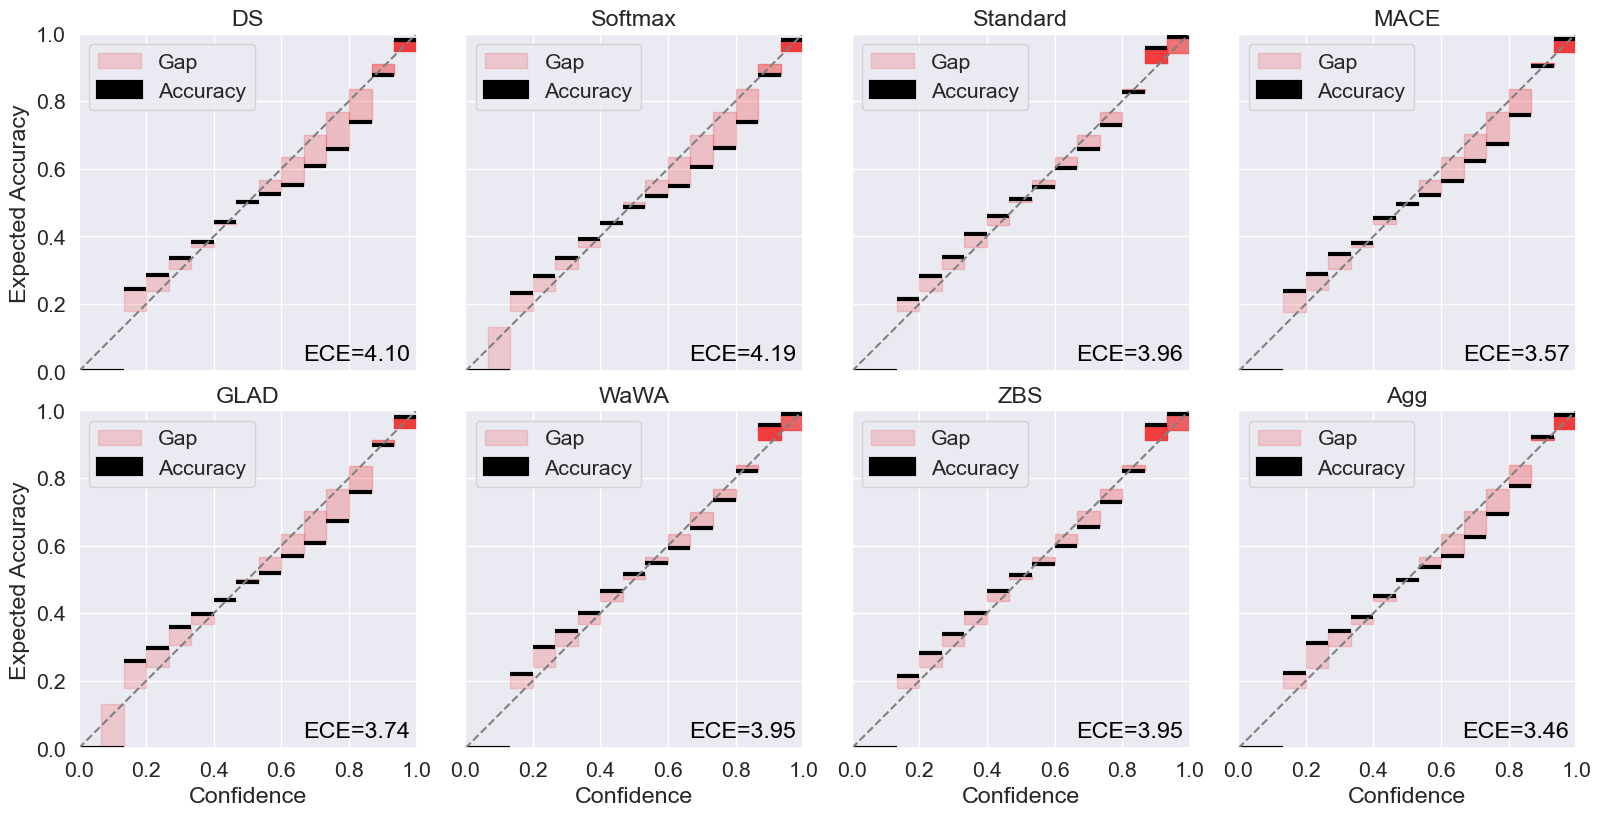

In [18]:
with sns.plotting_context("notebook", font_scale=1.4):
    fig = reliability_diagrams(data, num_bins=15, draw_ece=True,
                              draw_bin_importance="alpha", dpi=100, 
                              return_fig=True)
    fig.savefig('./cifar_reliability.pdf')

## Entropy and confidence with Jigsaw

In [19]:
def get_original_jigsaw_distribution(data):
    ids = set(data['id'])
    civilcomments_annotations = pd.read_csv('../data/jigsaw/civilcomments_toxicity_individual_annotations.csv')
    civilcomments_annotations = civilcomments_annotations[civilcomments_annotations['id'].isin(ids)]
    annotations = {}
    worker_to_colno = {}
    for i, (g, _) in enumerate(civilcomments_annotations.groupby('worker')):
        worker_to_colno[g] = i

    for g, group in civilcomments_annotations.groupby('id'):
        annotations[g] = [-1] * len(worker_to_colno)
        for j, row in group.iterrows():
            annotations[g][worker_to_colno[row['worker']]] = int((row['toxic'] + row['severe_toxic']) > 0)

    annotations = np.array([annotations[g] for g in data['id']])
    mask = annotations >= 0
    annotations[annotations < 0] = 0

    total_ones = annotations.sum(-1)
    total_zeros = mask.sum(-1) - total_ones
    class_logits = np.vstack([total_zeros, total_ones]).T

    standard_dist = class_logits / class_logits.sum(-1, keepdims=True)
    return standard_dist.tolist()

def read_jigsaw_data(data_dir, logits_file):
    # Collapse "very toxic" and "toxic" into one class and "not sure" and "not toxic" into another
    # The gold targets are the average number of annotations rated "not sure" and "not toxic",
    # so anything > 0.5 becomes class 1 and anything <= 0.5 becomes class 0
    label_map = {-2: 1, -1: 1, 0: 0, 1: 0}
    jigsaw_raw = pd.read_csv(f"{data_dir}/specialized_rater_pools_data.csv").fillna('')
    dataset = pd.read_csv(f"{data_dir}/gold.csv").fillna('')

    if os.path.exists(f"{data_dir}/formatted_annotations.csv"):
        annotations_df = pd.read_csv(f"{data_dir}/formatted_annotations.csv")
    else:
        annotations = []
        for g, group in jigsaw_raw.groupby('id'):
            for j, row in group.iterrows():
                if row['toxic_score'] != '':
                    annotations.append([g, row['unique_contributor_id'], label_map[row['toxic_score']]])
        annotations_df = pd.DataFrame(annotations, columns=['task', 'worker', 'label'])
        annotations_df.to_csv(f"{data_dir}/formatted_annotations.csv", index=None)

    annotations, _ = get_annotation_matrix(annotations_df, {i: i for i in range(2)})

    # First get standard and softmax distributions
    standard_dist = normalized_distribution(annotations, {i: i for i in range(2)})
    standard_dist = np.array([standard_dist[task] for task in dataset['id']])
    
    dataset = dataset[['id', 'comment_text', 'gold', 'split', 'target']]
    dataset.insert(len(dataset.columns), 'distribution', standard_dist.tolist())
    
    train_data = dataset[dataset['split'] == 'train']
    dev_data = dataset[dataset['split'] == 'val']
    test_data = dataset[dataset['split'] == 'test']

    test_data.insert(len(test_data.columns), 'original_distribution', get_original_jigsaw_distribution(test_data))
    
    logits = np.load(logits_file)
    
    return test_data, logits

def total_variation_distance(p, q):
    return 0.5 * (np.abs(p - q).sum(axis=-1))


In [22]:
test_jigsaw_data, jigsaw_logits = read_jigsaw_data('../data/jigsaw', '/Users/vcx366/Research/hendrix/learning-from-crowd-annotations/metrics/ds_mace_glad_wawa_zbs_softmax_standard/jigsaw/kld-ensemble_basic/logits_1000.npy')

In [23]:
(np.argmax(jigsaw_logits, -1) == test_jigsaw_data['gold']).mean()

0.779607843137255

In [30]:
jigsaw_logits = [
    ('DS', 'jigsaw/kld-ds/logits_*'),
    ('Softmax', 'jigsaw/kld-softmax/logits_*'),
    ('Standard', 'jigsaw/kld-standard/logits_*'),
    ('MACE', 'jigsaw/kld-mace/logits_*'),
    ('GLAD', 'jigsaw/kld-glad/logits_*'),
    ('WaWA', 'jigsaw/kld-wawa/logits_*'),
    ('ZBS', 'jigsaw/kld-zbs/logits_*'),
    ('Agg', 'jigsaw/kld-ensemble_basic/logits_*'),
    #('Centroid', 'jigsaw/kld-ensemble_centroid/logits.npy'),
    #('Majority', 'jigsaw/majority/logits_1000.npy')
]
# logits_dict = {}
# for name, fname in logits_fnames:
#     logits_dict[name] = np.load(f"{metrics_dir}/{fname}")

In [31]:
new_dists = np.array([list(a) for a in test_jigsaw_data['distribution']])
old_dists = np.array([list(a) for a in test_jigsaw_data['original_distribution']])
comb_dists = (new_dists + old_dists) / 2
# entropy_comb = entropy(comb_dists, axis=-1)
# jsd = jensenshannon(new_dists, old_dists, axis=-1)
# for name in logits_dict:
#     logits = logits_dict[name]
#     entropy_average = entropy(softmax(logits, axis=-1), axis=-1)
#     print(f"{name}: {pearsonr(entropy_average, entropy_comb)[0]}")

In [13]:
#pearsonr(jsd, entropy_average)

PearsonRResult(statistic=0.16738940376827727, pvalue=1.7588760970412806e-17)

In [47]:
data = defaultdict(dict)
for name, loc_super in jigsaw_logits:
    all_logits = []
    for fname in glob.glob(f"{metrics_dir}/{loc_super}"):
        all_logits.append(np.load(fname))
    logits = np.array(all_logits).mean(0)
    print(logits.shape)
    pred = logits.argmax(-1).astype(np.int32)
    conf = softmax(logits, -1).max(-1)
    data[name] = softmax(logits, -1)
data['gold'] = old_dists

(2550, 2)
(2550, 2)
(2550, 2)
(2550, 2)
(2550, 2)
(2550, 2)
(2550, 2)
(2550, 2)


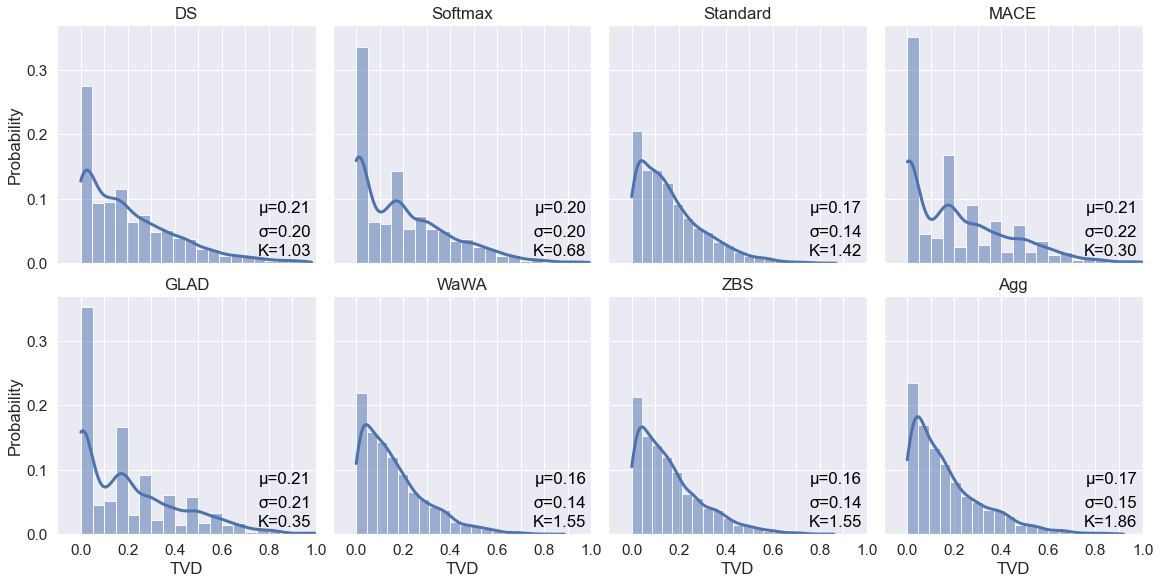

In [53]:
with sns.plotting_context("notebook", font_scale=1.4):
#     softmax_dict = {n: softmax(logits_dict[n], -1) for n in logits_dict}
#     softmax_dict['gold'] = comb_dists
    data['gold'] = old_dists
    fig = tvd_diagrams(data, num_cols=4, return_fig=True)
    #fig.tight_layout()
    fig.savefig('./jigsaw_tvd.pdf')

In [45]:
old_dists

array([[1. , 0. ],
       [1. , 0. ],
       [0.8, 0.2],
       ...,
       [1. , 0. ],
       [1. , 0. ],
       [0.6, 0.4]])

In [178]:
plt.get_cmap('Spectral')(0.5)

(0.998077662437524, 0.9992310649750096, 0.7460207612456747, 1.0)

## CLL and F1 line plots on RTE and POS

## RTE

In [313]:
rte_subsets_dir = '/Users/vcx366/Research/hendrix/learning-from-crowd-annotations/metrics/subsets/rte-ood-snli/'
avg_cll = defaultdict(list)
avg_f1 = defaultdict(list)

for n in range(2,7):
    for mfile in glob.glob(f"{rte_subsets_dir}/{n}/**/*.json"):
        with open(mfile) as f:
            d = json.loads(next(f))
        avg_cll[n].append(d['test_NLL_post'])
        avg_f1[n].append(d['F1'])
for n in avg_cll:
    avg_cll[n] = np.array(avg_cll[n]).mean()
    avg_f1[n] = np.array(avg_f1[n]).mean() * 100
# Use average from 10 runs for final value
avg_cll[7] = 0.5955
avg_f1[7] = 63.26

defaultdict(<class 'list'>, {2: [0.6818542003631591, 0.6932881236076355, 0.5470603585243226, 0.6742540955543518, 0.5356401681900025, 0.6932359099388122, 0.5096810221672058, 0.675135362148285, 0.6495152831077575, 0.6232004642486573, 0.5761468410491943, 0.6848161220550537, 0.6759234428405761, 0.6840713381767273, 0.5829601526260376, 0.6575578570365905, 0.5365857124328614, 0.6096074938774109, 0.6479179263114929, 0.5234772205352783, 0.480943089723587], 3: [0.472039657831192, 0.6785500168800354, 0.48730539083480834, 0.687510359287262, 0.6489384174346924, 0.6815954089164734, 0.7008585095405578, 0.4852562665939331, 0.48651167154312136, 0.5591178178787232, 0.517565929889679, 0.5675111174583435, 0.5862690448760987, 0.47845897674560545, 0.47003668546676636, 0.6478375434875489, 0.687743091583252, 0.6532700538635254, 0.6703106164932251, 0.644278347492218, 0.6858127236366272, 0.4853441774845123, 0.6903563499450683, 0.5876155376434327, 0.6970603585243225, 0.6804356813430786, 0.6207774639129638, 0.608

In [308]:
avg_cll

defaultdict(list,
            {2: 0.6163272468816666,
             3: 0.6071052261761256,
             4: 0.5972985872200557,
             5: 0.6313173427468255,
             6: 0.6645464164870126,
             7: 0.5955})

In [309]:
avg_f1

defaultdict(list,
            {2: 58.713925340177944,
             3: 62.09857471376586,
             4: 61.69023979605528,
             5: 58.318647007435146,
             6: 50.87435040928365,
             7: 63.26})

Text(0.5, 0, 'Number of Distributions')

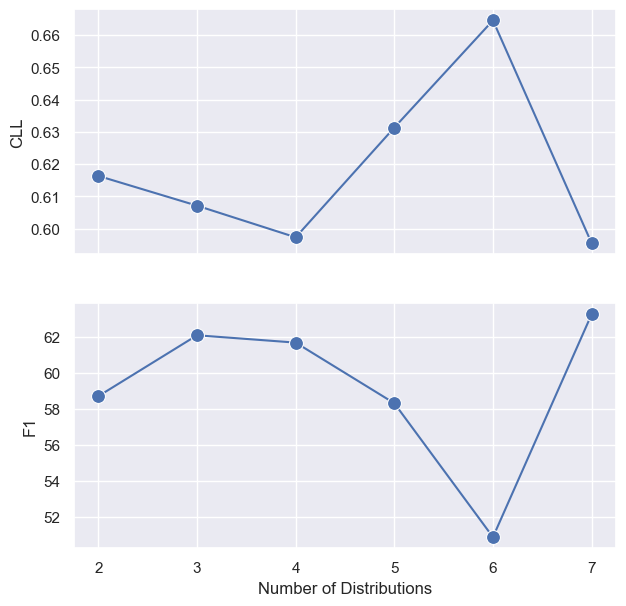

In [311]:
# star = mpath.Path.unit_regular_star(6)
# circle = mpath.Path.unit_circle()
# cut_star = mpath.Path(
#     vertices=np.concatenate([circle.vertices, star.vertices[::-1, ...]]),
#     codes=np.concatenate([circle.codes, star.codes]))
fig, ax = plt.subplots(2,1, figsize=(7,7))

x = list(range(2,7)) + [7]
sns.lineplot(x=x, y=[avg_cll[i] for i in x], ax=ax[0], marker='o', markersize=10)
ax[0].set_ylabel('CLL')
ax[0].set_xticks(x, labels=[])

sns.lineplot(x=x, y=[avg_f1[i] for i in x], ax=ax[1], marker='o', markersize=10)
ax[1].set_ylabel('F1')
ax[1].set_xlabel("Number of Distributions")

## POS

In [8]:
from copy import deepcopy
pos_subsets_dir = '/Users/vcx366/Research/hendrix/learning-from-crowd-annotations/metrics/subsets/pos-ood'
pos_subdirs = ['', '-666', '-1001']
cll_all = defaultdict(list)
f1_all = defaultdict(list)
mean_cll_all = defaultdict(list)
mean_f1_all = defaultdict(list)

for subdir in pos_subdirs:
    cll = defaultdict(list)
    f1 = defaultdict(list)
    mean_cll = defaultdict(list)
    mean_f1 = defaultdict(list)
    
    for n in range(2,8):
        for mfile in glob.glob(f"{pos_subsets_dir}{subdir}/{n}/**/*.json"):
            with open(mfile) as f:
                d = json.loads(next(f))
            cll[n].append(d['test_NLL_post'])
            f1[n].append(d['F1'])
        

    for n in cll:
        mean_cll_all[n].append(np.array([i for i in cll[n] if i < 1.5]).mean())
        mean_f1_all[n].append(np.array(f1[n]).mean() * 100)
        cll_all[n].append(cll[n])
        f1_all[n].append(f1[n])
avg_cll = defaultdict(list)
avg_f1 = defaultdict(list)
for n in cll_all:
    avg_cll[n] = np.array(cll_all[n]).mean()
    avg_f1[n] = np.array(f1_all[n]).mean()

In [42]:
cll = defaultdict(list)
f1 = defaultdict(list)
for n in cll_all:
    cll[n] = np.array(cll_all[n]).mean(0)
    f1[n] = np.array(f1_all[n]).mean(0)
    
avg_cll = defaultdict(list)
avg_f1 = defaultdict(list)
for n in cll_all:
    avg_cll[n] = np.array(cll_all[n]).mean()
    avg_f1[n] = np.array(f1_all[n]).mean()

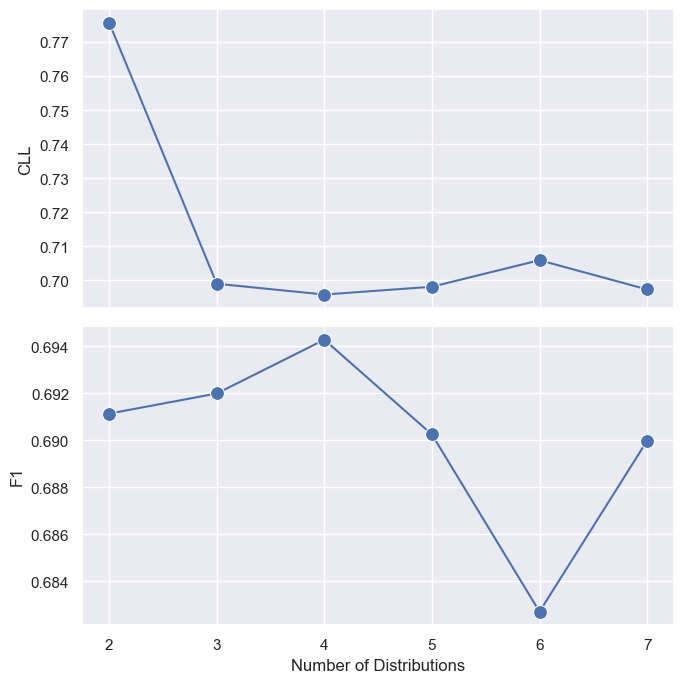

In [45]:
fig, ax = plt.subplots(2,1, figsize=(7,7))

x = list(range(2,8))
sns.lineplot(x=x, y=[avg_cll[i] for i in x], ax=ax[0], marker='o', markersize=10)
ax[0].set_ylabel('CLL')
ax[0].set_xticks(x, labels=[])

sns.lineplot(x=x, y=[avg_f1[i] for i in x], ax=ax[1], marker='o', markersize=10)
ax[1].set_ylabel('F1')
ax[1].set_xlabel("Number of Distributions")
plt.tight_layout()
plt.savefig('./pos_subsets_line.pdf')

In [33]:
mean_cll

defaultdict(list,
            {2: 0.7265501910448074,
             3: 0.7243789522988456,
             4: 0.7222093830789839,
             5: 0.7261832952499389,
             6: 0.7216153979301453,
             7: 0.6873})

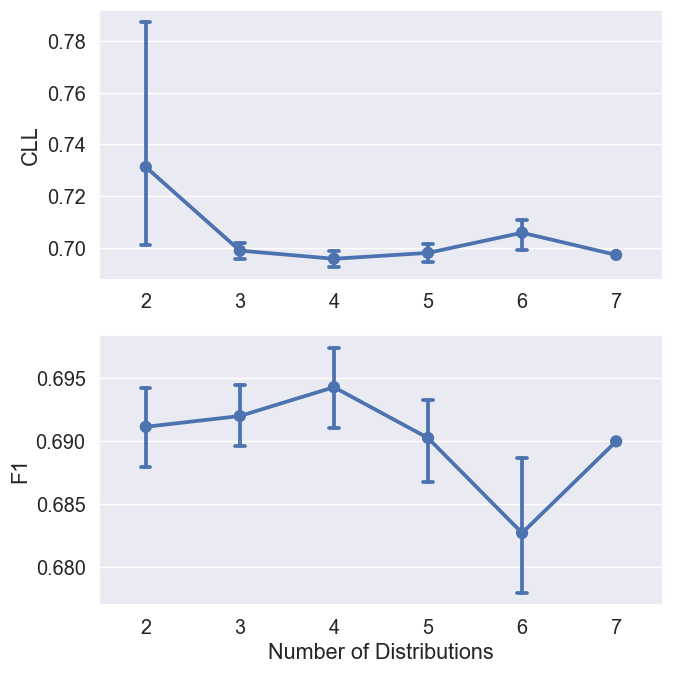

In [53]:
with sns.plotting_context("notebook", font_scale=1.3):
    scatter_x = [n for n in cll for i in cll[n] if i < 1.5]
    cll_y = [i for n in cll for i in cll[n] if i < 1.5]

    scatter_x_f1 = [n for n in cll for i in cll[n]]
    f1_y = [i for n in cll for i in f1[n]]

    fig, ax = plt.subplots(2,1, figsize=(7,7))

    x = list(range(2,7)) + [7]
    sns.pointplot(x=scatter_x, y=cll_y, errorbar='ci', capsize=0.1, ax=ax[0])
    #sns.lineplot(x=list(range(2,7)), y=[mean_cll[i] for i in range(2,7)], ax=ax[0])
    ax[0].set_ylabel('CLL')
    #ax[0].set_ylim((0.65, 0.75))
    #ax[0].set_xticks(x, labels=[])

    sns.pointplot(x=scatter_x_f1, y=f1_y, errorbar='ci', capsize=0.1, ax=ax[1])
    ax[1].set_ylabel('F1')
    ax[1].set_xlabel("Number of Distributions")

    plt.tight_layout()
    plt.savefig('./pos_subsets_point.pdf')

In [22]:
cll

defaultdict(list,
            {2: array([1.25284163, 0.68741014, 0.70724946, 0.69387047, 0.69900223,
                    1.66385382, 0.69495715, 0.72640557, 0.69105351, 0.70528432,
                    0.70118735, 0.70031666, 0.70886537, 0.70631923, 0.70151854,
                    0.7080723 , 0.70767858, 0.71196194, 0.70400136, 0.69815493,
                    0.71951501]),
             3: array([0.71501026, 0.7060305 , 0.70621843, 0.68493983, 0.68406431,
                    0.69254213, 0.70010324, 0.70605814, 0.68978531, 0.69927253,
                    0.70679243, 0.69300783, 0.69994028, 0.68769368, 0.69560358,
                    0.7016794 , 0.70167391, 0.69995975, 0.68720818, 0.6965564 ,
                    0.70121248, 0.7056537 , 0.67856614, 0.70394499, 0.69488766,
                    0.70767686, 0.70887542, 0.71239567, 0.70079444, 0.70536618,
                    0.70335902, 0.70722744, 0.6995117 , 0.67700258, 0.70200622]),
             4: array([0.70329123, 0.70863376, 0.68533725, 0